# FluxRETAP Tutorial - Generating gene targets for metabolic engineering

This notebook illustrates how to use FluxRETAP to guide selection of genetic targets for bioengineering purposes. 



import for image generation.

In [3]:
from IPython.display import Image

# Explanation of Method

FluxRETAP works by identifying reactions that have fluxes correlated or anticorrelated with product production. To do so, we simulate step-wise increases in product production (while optimizing for biomass) in a genome-scale model.

The below image demonstrates step-wise increase in production of indigoidine until we reach the theoretical max.


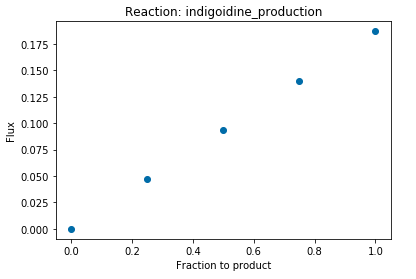

In [4]:
Image(filename='../images/productProduction.png')

At each product production level we perform flux variability analysis (FVA) to obtain every reaction's mininum and maximum values. 

For the GLUDy reaction corresponding to the indogoidine production simulation above, we obtain the following FVA profile:


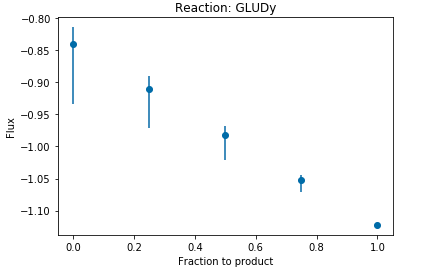

In [5]:
Image(filename='../images/reaction.png')

Scores representing the likelihood that a reaction is correlated or anticorrelated with increased production flux computed for every reaction using the FVA results from the two smallest and the two largest product production levels.

The procedure is as follows: 
1. Gaussian distributions are fit using the FVA results at the low and high production levels, by approximating the mean and standard deviation (µ, σ) of the distributions as the average and the difference between largest and smallest fluxes. 
2. Distribution overlap between the high and low production level Gaussians are computed. 
3. Final score is calculated as the inverse of the overlap (1/overlap).


A higher score means there is less overlap, indicating that the reaction flux values are likely to be significantly changed over the course of production.

The following image shows the two Gaussian distributions calculated from the GLUDy reaction example shown above.


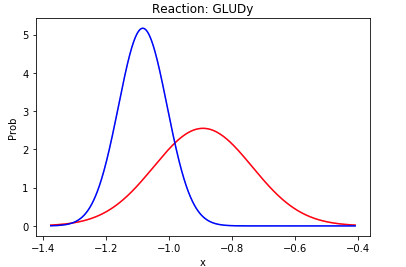

In [6]:
Image(filename='../images/Distributions.png')

Finally, FluxRETAP screens all returned reactions as single reaction deletions and returns the % of the normal growth rate that results when those reactions are deleted.

# Setup

The first step to use this notebook is to make sure that the required dependencies are installed.
* cobra
* scipy
* pandas
* numpy
* matplotlib

if the packages are not installed, you can use the following line from the command prompt to install:
> pip install cobra scipy pandas numpy matplotlib

## Imports

In [1]:
import cobra
from cobra import Metabolite, Reaction
import os
import sys
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import Image   # Used to display images

importing FluxRETAP

In [2]:
# set the library path
libraryPath = "../../FluxRETAP"
sys.path.append(libraryPath)

# import FluxRETAP module
from core.FluxRETAP import FluxRETAP

You are using cobra version:  0.29.0


## GSM preparation

* load the GSM (*E. coli* model [iJO1366](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3261703/) modified to include the isoprenol production)
* add the heterogenous indigoidine pathway

for instructions on using cobra, visit the [COBRApy documentation](https://opencobra.github.io/cobrapy/)


### load GSM

In [3]:
## set the path to the GSM to be used
# E. coli GSM iJO1366
file_name = '../models/iJO1366_MVA.json' 

# Load the GSM (json format)
model = cobra.io.load_json_model(file_name)

### Add heterologous indigoidine production pathway 

In this example, we will be examing production of the non-native product indigoidine. 

Two reactions are needed to enable indigoidine production:
1. ATP:pantetheine 4'-phosphotransferase (APNPT, creating indigoidine precursor)
2. Indigoidine production reaction

The next 5 cells below add the pathway and metabolites. 

In [4]:
# initialize the reaction object and set the bounds (APNPT)
APNPT = Reaction('APNPT')
APNPT.name = 'ATP:pantetheine 4\'-phosphotransferase'
APNPT.subsystem = 'Cytosol'
APNPT.lower_bound = -1000
APNPT.upper_bound = 1000


# initialize the reaction object and set the bounds (Indigoidine production)
product_rxn = Reaction('indigoidine_production')
product_rxn.name = 'Indigoidine production'
product_rxn.subsystem = 'Cytosol'
product_rxn.lower_bound = 0
product_rxn.upper_bound = 1000

# add reaction to the model
model.add_reactions([product_rxn,APNPT])

In [5]:
# initialize the non-native metabolites 

# metabolite one (Pantetheine)
ptth_c = Metabolite(
    'ptth_c',
    formula='C11H22N2O4S',
    name='Pantetheine',
    compartment='c'
)


# metabolite two (Indigoidine)
indigoidine_c = Metabolite(
    'indigoidine_c',
    formula ='C10H8N4O4',
    name = 'Indigoidine',
    compartment='c'
)

In [6]:
### add the stochiometrically balanced reaction to the model
## note - the names are metabolites names as they appear in the GSM
# APNPT reaction
APNPT.add_metabolites({
    'atp_c': -1,
    ptth_c: -1,
    'adp_c': 1,
    'h_c':1,
    'pan4p_c':1
})

# Indigodine product reaction
product_rxn.add_metabolites({
    'gln__L_c': -2,
    'atp_c': -2,
    'coa_c': -2,
    'fmn_c': -2,
    'o2_c': -2.5,
    'pap_c':2,
    'fmnh2_c': 2,
    'ppi_c': 2,
    'amp_c': 2,
    ptth_c: 2,
    'h2o_c': 1,
    'pi_c': 2,
    indigoidine_c: 1   
})


Verify that the reactions have been added and that the mass is balanced. 

In [7]:
# APNPT reaction
model.reactions.get_by_id('APNPT').check_mass_balance()

{}

In [8]:
# Indigoidine product reaction
model.reactions.indigoidine_production.check_mass_balance()

{'charge': -6.0}

In [9]:
# Create a demand reaction for indigoidine to allow it to accumulate in the model
demand = model.add_boundary(model.metabolites.indigoidine_c,type="demand")

## FluxRETAP Initialization

FluxRETAP has parameters the user can adjust to based on the target reaction, carbon source, biomass equation, etc. These paremeters are introduced in the following cells. 

### Required Parameters

The following parameters are required. 
1. **uptakeRxn**  (string)
    - specifies the substrate source 
2. **biomassRxn** (string)
    - specifies the biomass reaction (or the objective to optimize during FVA)
3. **productRxn** (string)
    - specifies the target product 

The input to all of these are the string names of the cobrapy reaction ID.





In [10]:
# specifiying the required parameters for GSM iJO1366
productRxn = 'indigoidine_production' # product to make
uptakeRxn = 'EX_glc__D_e' # carbon source to grow on 
biomassRxn = 'BIOMASS_Ec_iJO1366_core_53p95M' # biomass equation

### Optional parameters

The following parameters can effect the returned reactions:
1. **desiredSystems** (list)
    - metabolic subsystems to return reactions from (i.e, TCA cycle, glycolysis, etc.)
2. **N** (int) 
    - number of steps to divide the production space into (i.e, 10 steps to go reach maximum theoretical production)
3. **referenceCutOff** (int or list)
    - threshold for the returned reaction scores
4. **returnOreturnGaussian** (bool)
    - return the calculated Gaussians (True) or only the reaction score information (False) - Gaussians can be used for downstream plotting analysis. 
5. **optimalFraction** (float)
    - set the fraction of the maximum growth rate to simulate 
6. **fluxRangeDiff** (float)
    - set the minimal threshold for differences between flux ranges (i.e., reactions must very by at least 1 mmol/g/DCW)
7. **UpOrDown** (string)
    - return reactions that increase ("Up") or decrease ("Down") with increasing production - "Both" can be used to return both increasing and decreasing reactions
8. **Ors** (bool)
    - return reactions that have "or" gene_reaction rules (True) (i.e., more than one gene encodes an enzyme that corresponds to a reaction).
9. **fast** (bool)
    - simulate every step in N (False) or only the steps needed for score calculations (True)
10. minGrowth (float)
    - minimal biomass growth for selecting reactions

#### Parameter explanations

**1. desired_systems**: list of subsystems (as specified in the passed GSM) that you would accept target reactions from

In [11]:
# reaction subsystems to incldue in the analysis. Note this is specific to the iJO1366 model
desired_systems = ['Glycolysis/Gluconeogenesis',
                    'Citric Acid Cycle',
                    'Alanine and Aspartate Metabolism',
                    'Alternate Carbon Metabolism',
                    'Threonine and Lysine Metabolism',
                    'Anaplerotic Reactions',
                    'Murein Biosynthesis',
                    'Methylglyoxal Metabolism',
                    'Tyrosine, Tryptophan, and Phenylalanine Metabolism',
                    'Valine, Leucine, and Isoleucine Metabolism',
                    'Nitrogen Metabolism',
                    'Methionine Metabolism',
                    'Cysteine Metabolism',
                    'Histidine Metabolism',
                    'Glycine and Serine Metabolism',
                    'Folate Metabolism',
                    'Glutamate Metabolism',
                    'Glyoxylate Metabolism',
                    'Anaplerotic Reactions',
                    'Murein Biosynthesis',
                    'Cytosol',                   
                  ]

**2. N** - number of steps to divide the production space into

Increasing steps means that each step has smaller flux differences compared to the prior step and can lead to tighter distributions and a larger number of significant reactions returned. 

Default value = 10

In [12]:
N=10

**3. referenceCutOff** - threshold for the returned reaction scores

Only returns reactions with scores higher than the referenceCutOff score. 

Two different types of inputs can be provided to the parameter: 
   1. Number (e.g., 500, 1000, 2500, etc)
   2. List of reactions (e.g., ['GLNS','GLUSy','GLUDy'])
    
If a list is provided, the referenceCutOff score is calculated as the average of all the reactions provided. 

Default value = 500

In [13]:
referenceCutOff = 500

**4. returnGaussian** - return the calculated Gaussians (True) or only the reaction score information (None) 

FluxRETAP returns the reactions and associated data (i.e., subsystem the reaction belongs to, associated genes, etc) by default. The algorithm can also return the associated Gaussian distributions that are used to calculate the scores when this parameter is specified as true. 

Default value = False 

In [14]:
returnGaussian = False

**5. optimalFraction** - set the fraction of the maximum growth rate to simulate.

Minimal fraction of biomass growth to occur in the production simulations. The minimal biomass is the specified fraction of the theoretical maximum of biomass produced when no product is being formed. 

Default value = 0.0

In [15]:
optimalFraction = 0.0

**6. fluxRangeDiff** - minimal threshold for differences between flux ranges

Minimal flux range difference required between the FVA optimal values for the reactions to be elgible for return. i.e., If a the flux through a reaction changes by 0.005 $\frac{mmol}{gDCW.h} $. between the instance with full biomass and the instance with max product, the algorithm will not return the reaction because it is below the default range of 0.01 $\frac{mmol}{gDCW.h} $. The flux range is calculated as the difference between the averages of the maximum and minimum values from FVA at the initial and final production levels.  

Default value = 0.01$\frac{mmol}{gDCW.h} $ 

In [16]:
fluxRangeDiff = 0.01

**7.  UpOrDown** - return reactions that increase ("Up") or decrease ("Down") with increasing production - "Both" can be used to return both increasing and decreasing reactions


* 'Down' - select targets that decrease as production increases (i.e., potential down-regulation targets)
* 'Up' - select targets that increase as production increases ((i.e., potential up-regulation targets)
* 'Both' - return all correlated/negatively correlated reactions

Default value = 'Both'

In [17]:
UpOrDown = 'Down'

**8. Ors** - return reactions that have "or" gene_reaction rules

Some reactions in the model have multipe genes that encode proteins that perform the same function (i.e., isozymes). 

- True - returns reactions that have "or" rules
- False - ignores reactions that have "or" rules

Default value = False

In [18]:
Ors=False

**9. fast** - simulate every step in N (False) or only the steps needed for score calculations (True)

This option speeds up simulations by only simulating the flux steps needed for calculating scores. Setting as False simulates every steps, which may be used for visualizing particular reaction behavior as production increases. 

Default value = True

In [19]:
fast=False

**10. minGrowth** - minimal biomass growth for selecting reactions when the reactions are removed from the model.

This option is a threshold. For each reaction target, FluxRETAP performs a single reaction deletion and determines the percent of the wildtype growth rate of the resulting mutant. The minGrowth threshold specifies a minGrowth.

Default value = 0.0

# Simulation

### run FluxRETAP simulations

FluxRETAP performed on *E. coli* GSM iJO1366 that has been modified for indigoidine production

In [20]:
### returnGaussian are set to True to plot the Gaussians
## simulation is faster when returnGaussian set to False
# 'ranges', 'initGaussian', 'finGaussian' are only returned when returnGaussian are set to True
selected,ranges,initGaussian,finGaussian = FluxRETAP.getRecommendations(model=model,
                                                              UpOrDown=UpOrDown,
                                                              productRxn=productRxn,
                                                              carbonSourceRxn=uptakeRxn,
                                                              biomassRxn=biomassRxn,
                                                              desiredSystems=desired_systems,
                                                              N=N, 
                                                              referenceCutOff=referenceCutOff,
                                                              returnGaussian=True,
                                                              optimalFraction=optimalFraction,
                                                              fluxRangeDiff=fluxRangeDiff,
                                                              fast=False)


Fractions of flux: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Maximum flux to product: 4.374528301886798

starting FVA simulations . . .
100.0 % complete
--- 536.0925030708313 seconds ---

Calculating significance scores
##################
Your cuttoff score is 500
The median reaction score in the dataset is 449 and the average is 6612074256
##################



In [21]:
# len of returned reactions. 
len(selected)

13

In [22]:
# examine the output dataframe
selected.head(10)

,score,trend,ors?,ands?,subsystem,fluxDiff,FinalFlux,In,growth %,bgene,geneName
IPPMIa,4.622843e+09,Down,False,True,"Valine, Leucine, and Isoleucine Metabolism",0.044634,1.335514e-14,True,6.269118e-16,b0071 and b0072,"[leuD, leuC]"
PPND,1.841026e+08,Down,False,False,"Tyrosine, Tryptophan, and Phenylalanine Metabo...",0.013845,1.615496e-14,True,1.062307e-14,b2600,[tyrA]
PGCD,4.248532e+04,Down,False,False,Glycine and Serine Metabolism,0.172437,0.000000e+00,True,9.779047e-01,b2913,[serA]
PSP_L,4.248532e+04,Down,False,False,Glycine and Serine Metabolism,0.172437,1.061993e-12,True,9.779047e-01,b4388,[serB]
PSERT,4.248532e+04,Down,False,False,Glycine and Serine Metabolism,0.172437,9.260197e-13,True,9.779047e-01,b0907,[serC]
GHMT2r,1.602874e+04,Down,False,False,Glycine and Serine Metabolism,0.110084,-1.504327e-14,True,9.857361e-01,b2551,[glyA]
MTHFD,2.442052e+03,Down,False,False,Folate Metabolism,0.099285,2.192635e-14,True,9.881168e-01,b0529,[folD]
MTHFC,2.442052e+03,Down,False,False,Folate Metabolism,0.099285,-5.781291e-14,True,9.881168e-01,b0529,[folD]
VALTA,5.706126e+02,Down,False,False,"Valine, Leucine, and Isoleucine Metabolism",0.049291,6.394885e-14,True,1.000000e+00,b3770,[ilvE]
SUCOAS,5.701405e+02,Down,False,True,Citric Acid Cycle,0.108488,-5.000000e+01,True,9.970561e-01,b0728 and b0729,"[sucC, sucD]"


### Plotting Gaussian distributions

In [23]:
# select a subset of reactions to plot the Gaussian distributions
rxns = list(selected[0:10].index)
rxns

['IPPMIa',
 'PPND',
 'PGCD',
 'PSP_L',
 'PSERT',
 'GHMT2r',
 'MTHFD',
 'MTHFC',
 'VALTA',
 'SUCOAS']

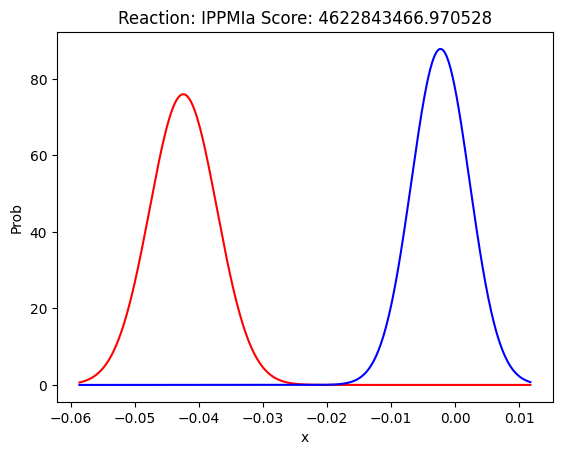

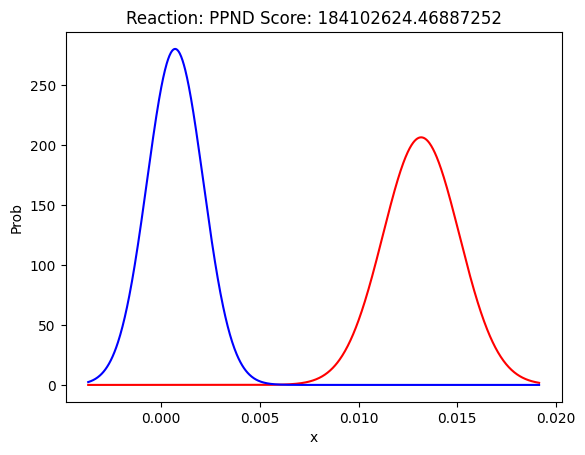

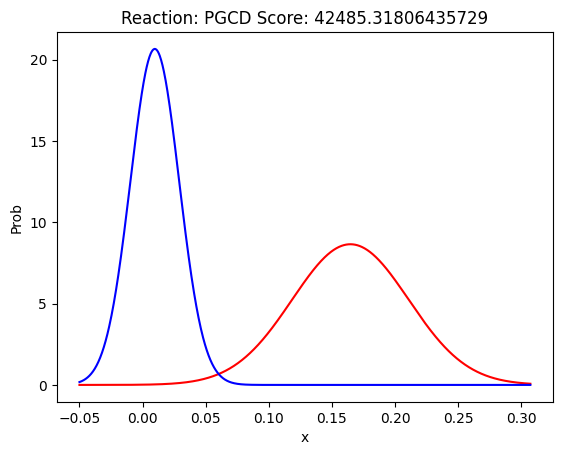

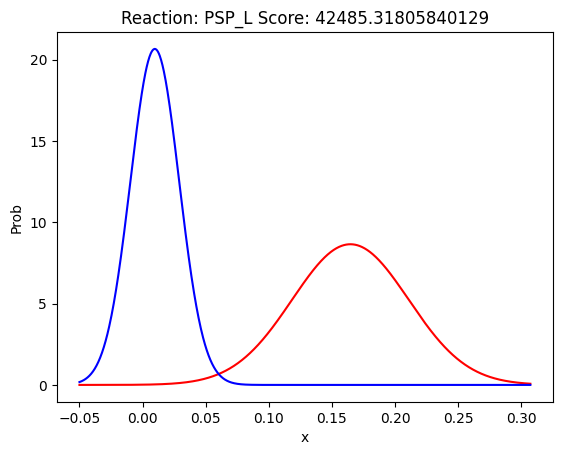

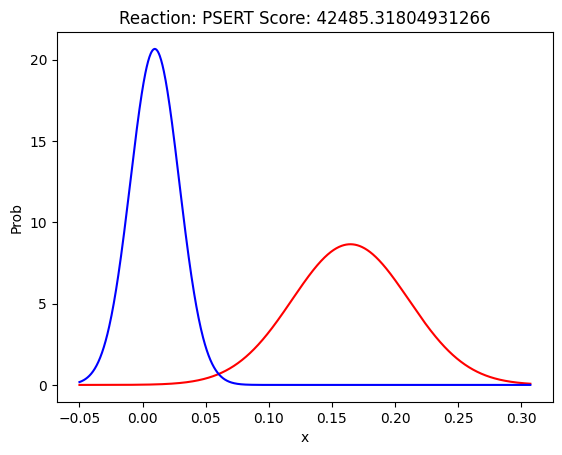

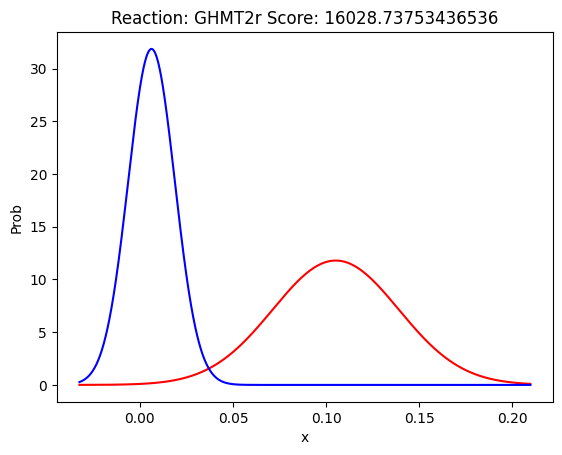

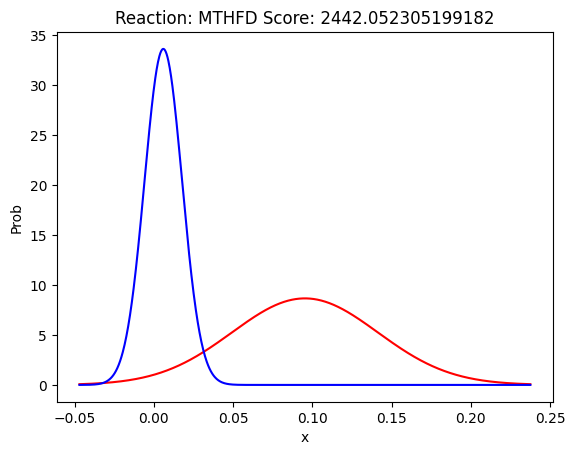

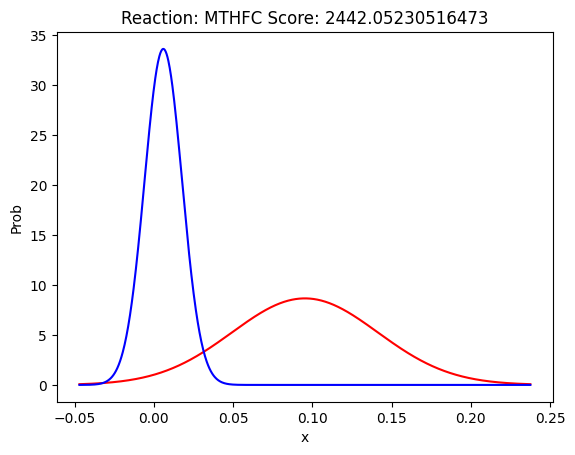

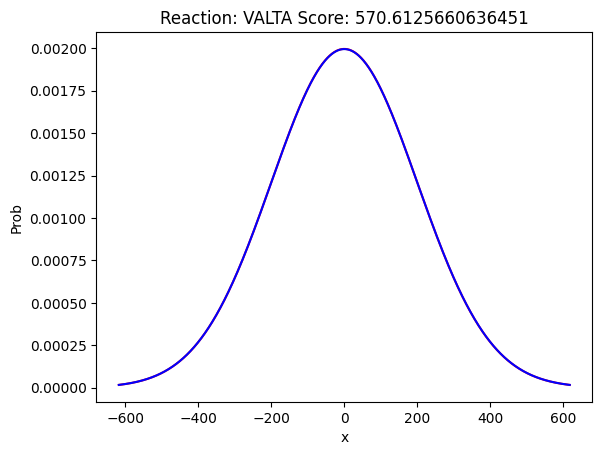

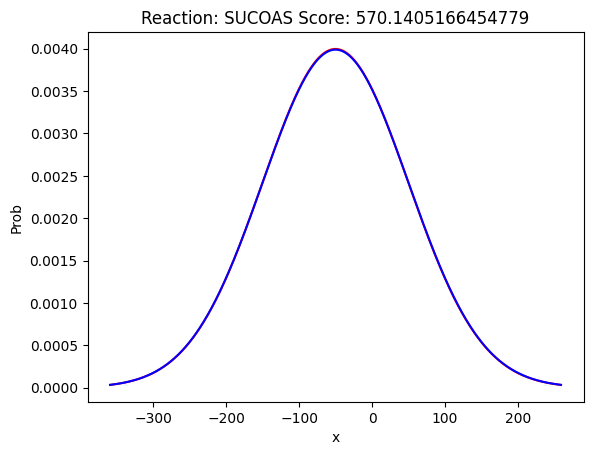

In [24]:
# plot the Guassian Distributions using "plotDists" function in FluxRETAP
FluxRETAP.plotDists(rxns,initGaussian, finGaussian)

### Plotting reaction behavior over ranges


#### Plot entire production step range (parameter N)

this pertains to how to use the plotRanges function when the following is specified during simulations
- returnGaussian=True
- fast=False

In [25]:
# obtain the number range of fractions to plot 
fractions = [x/N for x in range(0,N+1)]

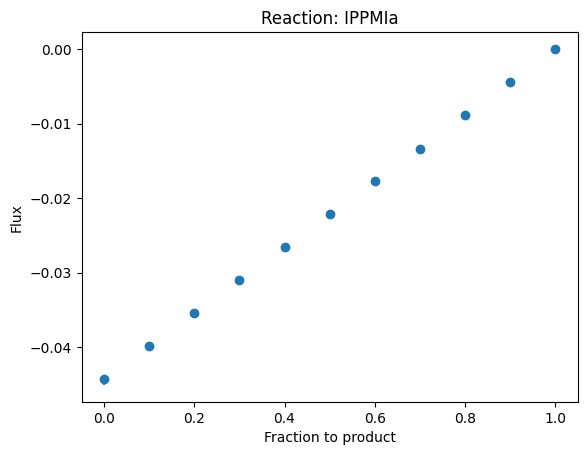

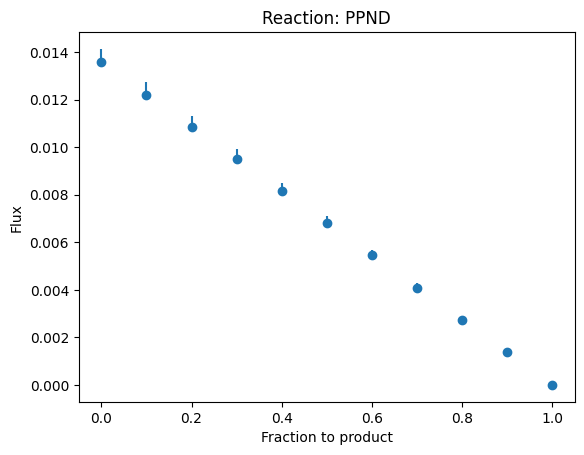

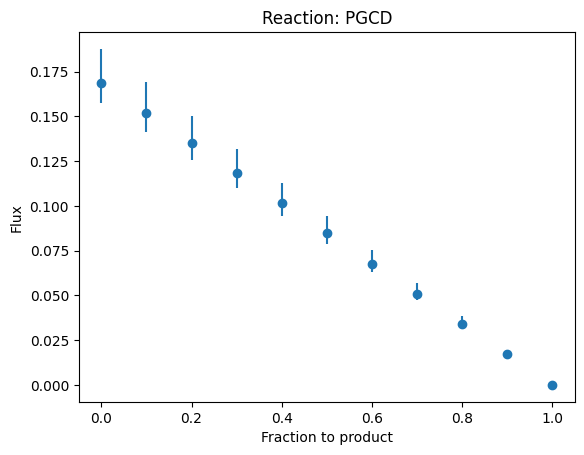

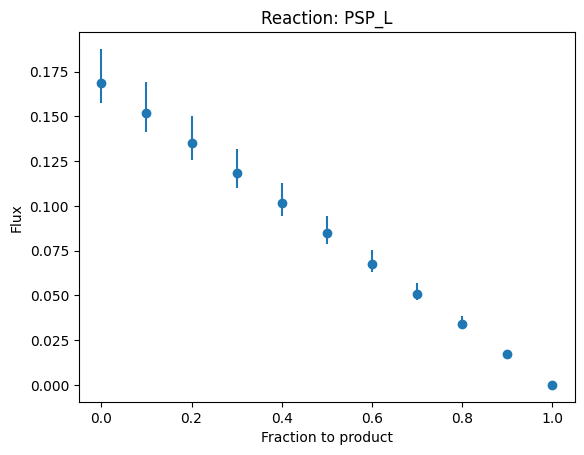

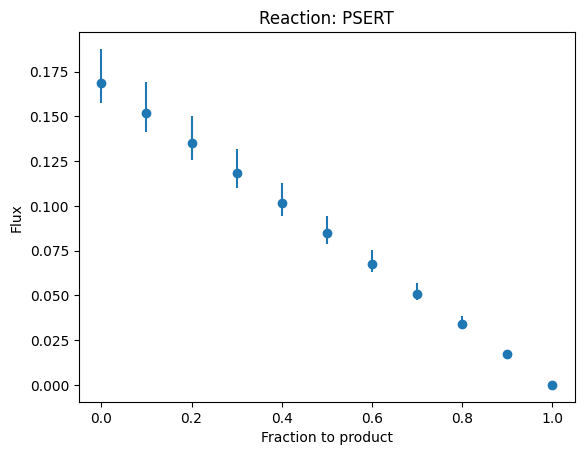

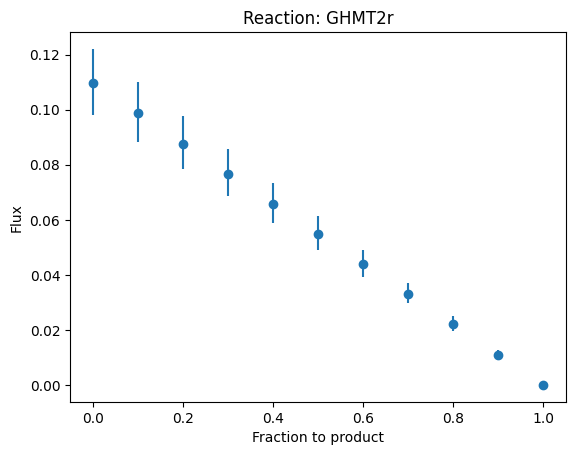

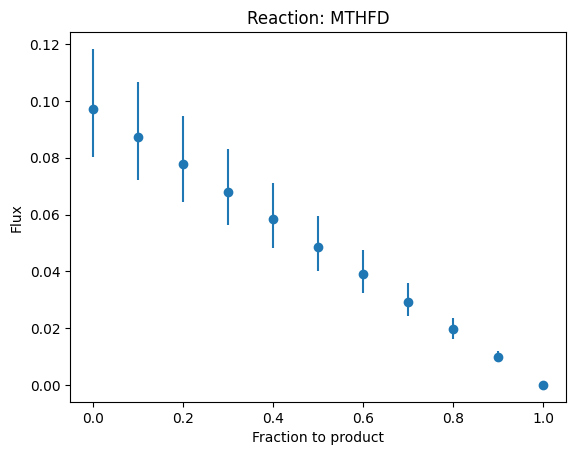

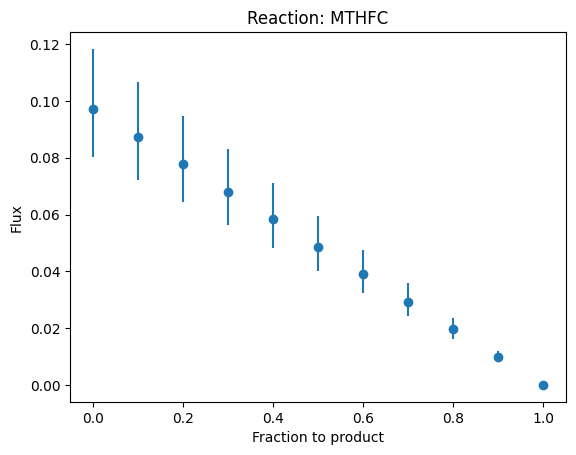

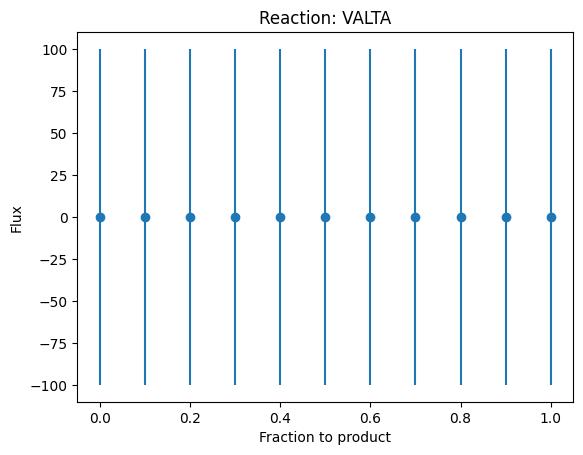

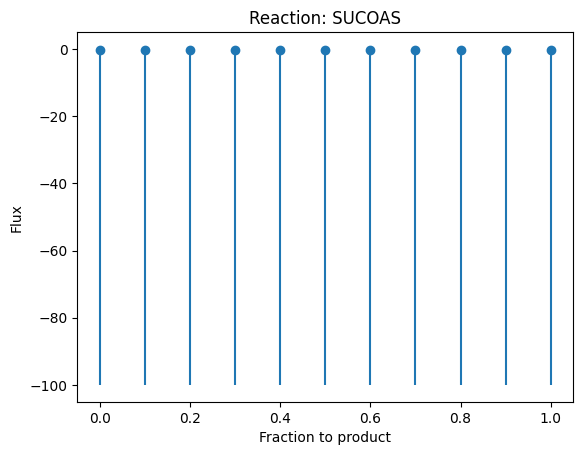

In [26]:
## iterate through reactions to plot
# ranges is returned when retureturnGaussian is set to True
for rxn in rxns:
    FluxRETAP.plotRanges(rxn, fractions, ranges)

#### Plot partial N range

this pertains to how to use the plotRanges function when the following is specified during simulations:
- returnGaussian=True
- fast=True

In [27]:
# obtain the number range of fractions to plot 
fractions = [x/N for x in range(0,N+1)]

In [28]:
# select the two minimal and two maximum N steps
simulatedValues = [fractions[0],fractions[1],fractions[len(fractions)-2],fractions[len(fractions)-1]]

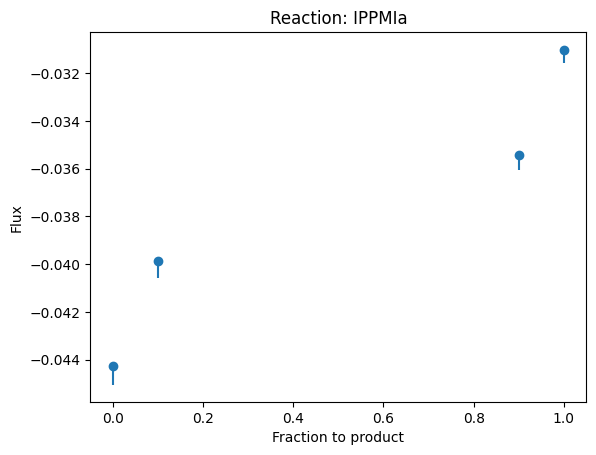

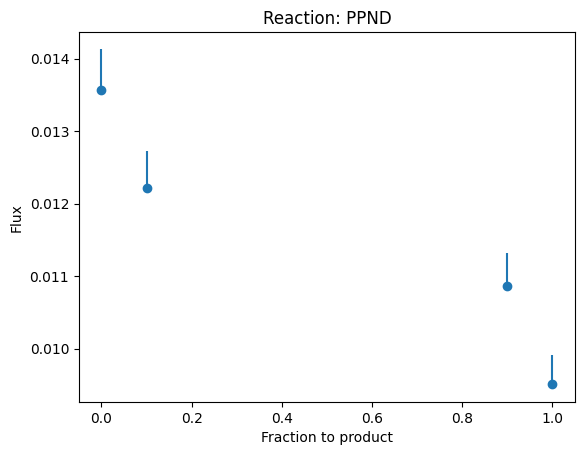

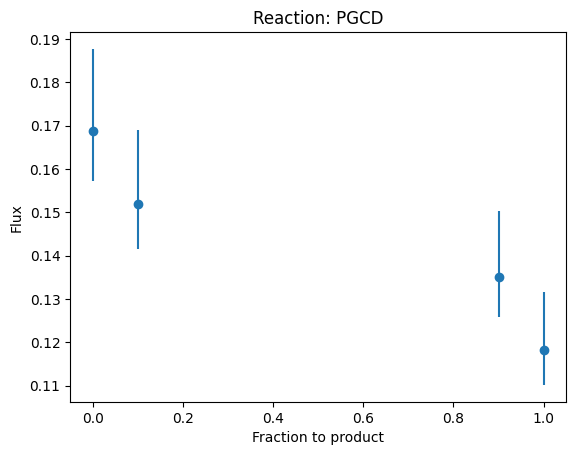

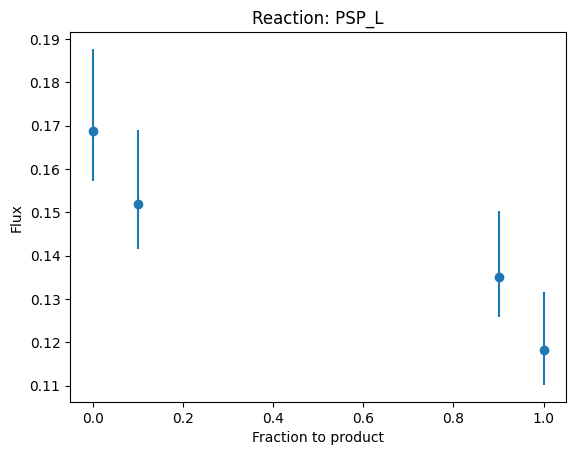

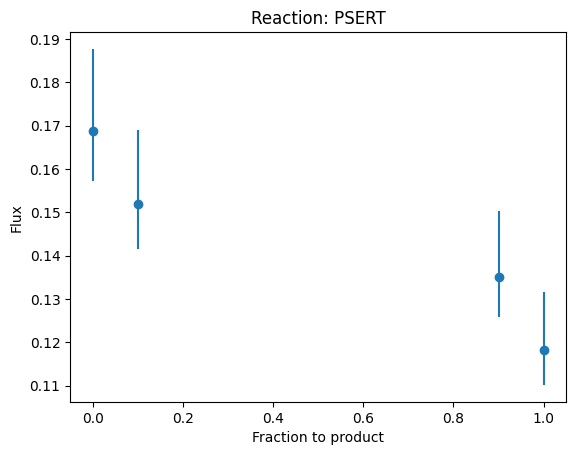

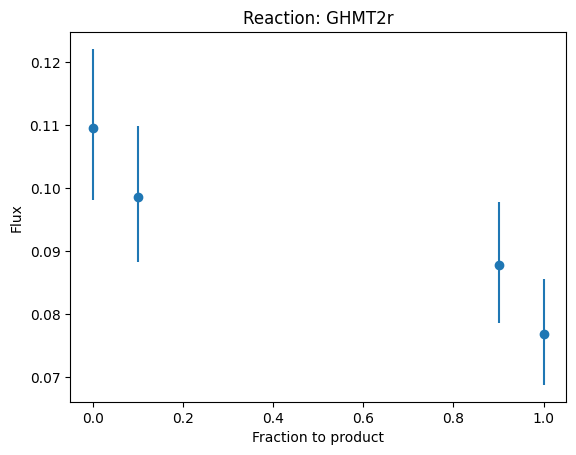

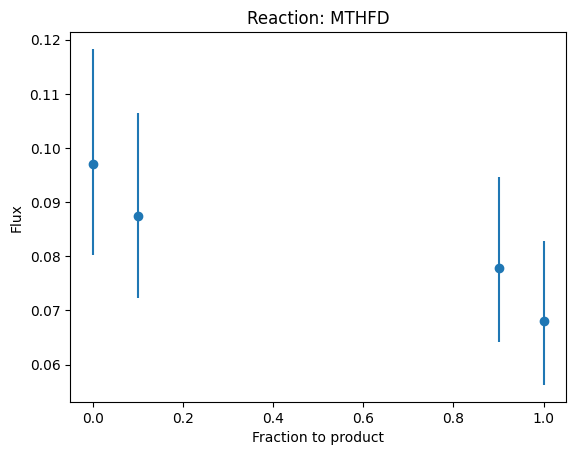

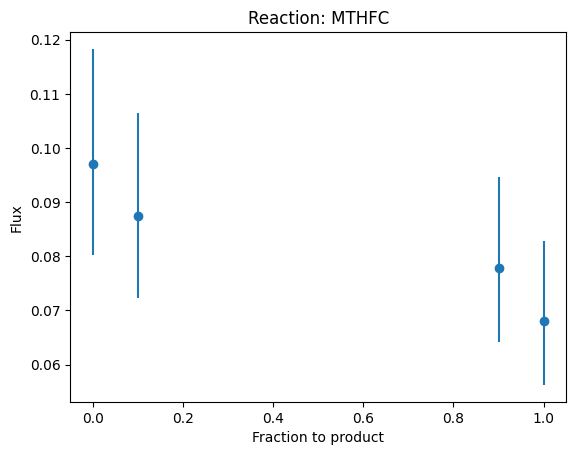

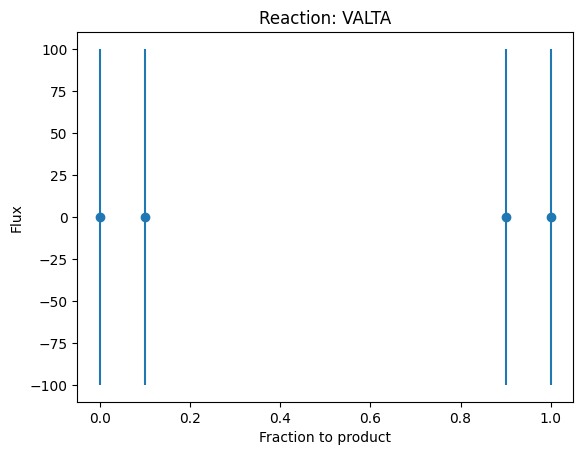

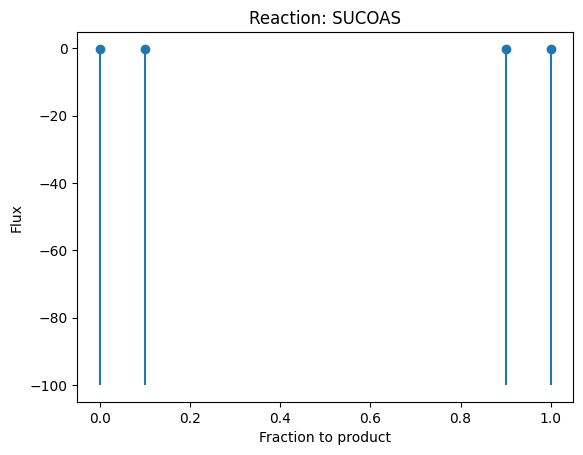

In [29]:
### ranges is returned when returreturnGaussian is set to True
## plotting a subset of fractions
# iterate through reactions to plot
for rxn in rxns:
    FluxRETAP.plotRanges(rxn, simulatedValues, ranges)